In [1]:
import numpy as np
import pymc3 as pm
import scipy.stats as st
import matplotlib.pylab as plt
import theano
import theano.tensor as tt

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
w0 = np.array([.3, .7])
mu0 = np.array([-1, 2])
sd0 = 1.
x = pm.NormalMixture.dist(w=w0, mu=mu0, sd=sd0).random(size=500)
x.shape

(500,)

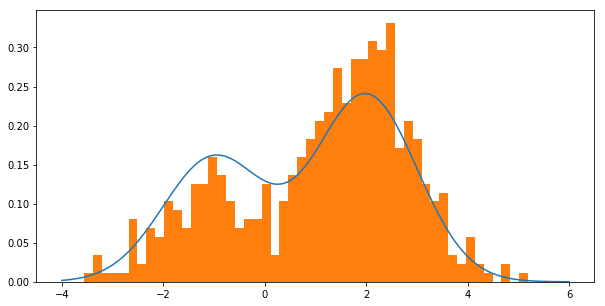

In [3]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
xrange = np.linspace(-4., 6, 100)
pdf = .4*st.norm.pdf(xrange, -1, 1.) + .6*st.norm.pdf(xrange, 2, 1.)
ax.plot(xrange, pdf)
ax.hist(x, 50, density=True);

In [4]:
with pm.Model() as m0:
    mu = pm.Normal('mu', 0., 5., shape=2)
    pm.NormalMixture('y', 
                     w=w0, 
                     mu=mu, 
                     sd=theano.shared(1.),
                     observed=x)

In [5]:
logp0 = m0.logp

In [6]:
point = m0.test_point
point

{'mu': array([0., 0.])}

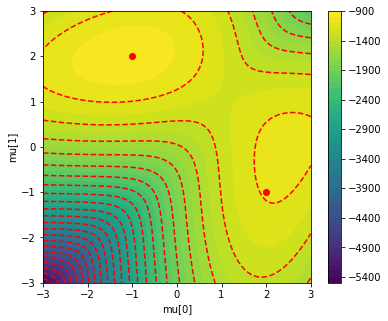

In [7]:
def disp_logp(model,
              mu0=np.linspace(-3, 3, 100),
              mu1=np.linspace(-3, 3, 100),
              transform=lambda x: x,
              ):
    logp = model.logp
    point = model.test_point
    mu0v, mu1v = np.meshgrid(mu0, mu1)

    ll = np.zeros_like(mu0v)
    lly = ll.flatten()
    for i in range(len(lly)):
        point[model.free_RVs[0].name] = transform(
            np.asarray([mu0v.flatten()[i],
                        mu1v.flatten()[i]]))
        lly[i] = logp(point)
    lly = lly.reshape(mu0v.shape)

    _, ax = plt.subplots(1, 1, figsize=(6, 5))
    # ax.imshow(lly, 
    #           origin='lower',
    #           cmap='viridis',
    #           extent=[mu0[0], mu0[-1], mu1[0], mu1[-1]],)
    CS = ax.contourf(mu0v, mu1v, lly, 50, cmap='viridis', origin='lower')
    CS2 = ax.contour(CS, levels=CS.levels[::2], colors='r', origin='lower')
    ax.plot([-1, 2], [2, -1], 'or')
    ax.set_xlabel('mu[0]')
    ax.set_ylabel('mu[1]')
    plt.colorbar(CS, ax=ax);
    return ax, lly

ax, logp = disp_logp(m0);

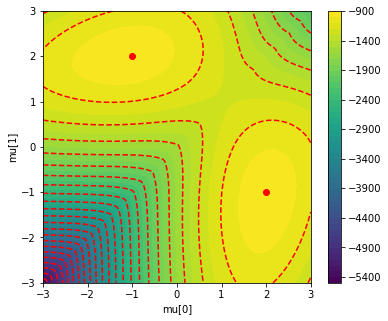

In [8]:
with pm.Model() as m1:
    mu = pm.Normal('mu', 0., 5., shape=2)
    mu_ = tt.sort(mu)
    pm.NormalMixture('y', 
                     w=w0, 
                     mu=mu_, 
                     sd=theano.shared(1.),
                     observed=x)

ax, logp = disp_logp(m1);

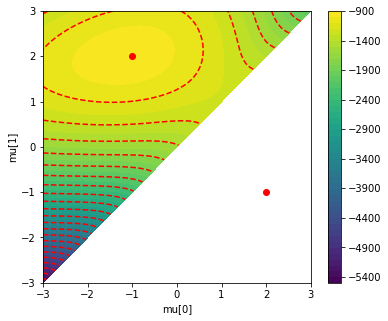

In [9]:
with pm.Model() as m2:
    mu = pm.Normal('mu', 0., 5., shape=2)
    pm.NormalMixture('y', 
                     w=w0, 
                     mu=mu, 
                     sd=theano.shared(1.),
                     observed=x)
    pm.Potential('order', tt.switch(mu[1]<mu[0], -np.inf, 0))

ax, logp = disp_logp(m2);

In [10]:
from pymc3.distributions.transforms import ordered

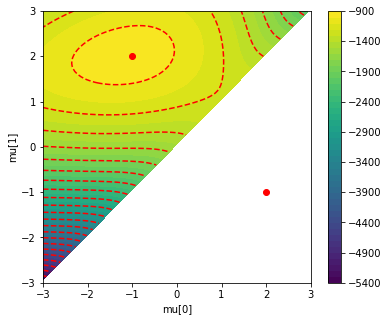

In [11]:
with pm.Model() as m3:
    mu = pm.Normal('mu', 0., 5., 
                   shape=2, 
                   transform=ordered,
                   testval=np.array([0., 1.]))
    pm.NormalMixture('y', 
                     w=w0, 
                     mu=mu, 
                     sd=theano.shared(1.),
                     observed=x)

ax, logp = disp_logp(m3, transform=ordered.forward_val);